Split the dataset into training and test set for fair comparison between the models

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import random


In [3]:
# Step 1: Define Dataset and DataLoader
data_dir = 'data'

In [4]:
# Transformations: Resize, Normalize
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

In [5]:
# Load Dataset
dataset = ImageFolder(root=data_dir, transform=transform)
torch.save(dataset, "dataset.pth")

In [10]:
import random
from collections import defaultdict

# 1. Raggruppa indici per writer_id (label originali)
writer_to_indices = defaultdict(list)
for idx, sample in enumerate(dataset):
    writer_to_indices[sample[1]].append(idx)

# 2. Escludi utenti con meno di tre campioni
filtered_writer_to_indices = {w: s for w, s in writer_to_indices.items() if len(s) > 2}

# 3. Lista utenti rimasti e split autorizzati/non autorizzati
all_writer_ids = list(filtered_writer_to_indices.keys())
random.seed(19)
random.shuffle(all_writer_ids)

split_index = int(0.8 * len(all_writer_ids))
authorized_writers = set(all_writer_ids[:split_index])
unauthorized_writers = set(all_writer_ids[split_index:])

# 4. Crea indici train/test
train_indices = []
test_auth_samples = []  # test samples autorizzati
test_unauth_samples = []  # test samples non autorizzati (1 per utente)

for writer in authorized_writers:
    indices = filtered_writer_to_indices[writer]
    random.shuffle(indices)
    n = len(indices)
    
    if n == 3:
        train_split = 2
    elif n == 4:
        train_split = 3
    else:
        train_split = int(n * 0.8)
    
    # Safety net: assicurati almeno 1 sample in test
    if n - train_split < 1:
        train_split = n - 1

    train_indices.extend(indices[:train_split])
    test_auth_samples.extend(indices[train_split:])

for writer in unauthorized_writers:
    # prendi un solo campione casuale per ogni utente non autorizzato
    sample = random.choice(filtered_writer_to_indices[writer])
    test_unauth_samples.append(sample)

# Combina test set bilanciato
test_indices = test_auth_samples + test_unauth_samples
random.shuffle(test_indices)

print(f"Train set: {len(train_indices)} campioni (solo autorizzati)")
print(f"Test set: {len(test_indices)} campioni (autorizzati + non)")

# 5. Crea label_map SOLO per gli utenti nel training set
train_labels_orig = [dataset[idx][1] for idx in train_indices]
unique_train_labels = sorted(set(train_labels_orig))

label_map = {orig_label: new_label for new_label, orig_label in enumerate(unique_train_labels)}

# 6. (facoltativo) Ricodifica i label del test set: -1 per utenti non autorizzati
test_labels_orig = [dataset[idx][1] for idx in test_indices]
test_labels_mapped = [
    label_map[label] if label in label_map else -1
    for label in test_labels_orig
]


Train set: 567 campioni (solo autorizzati)
Test set: 201 campioni (autorizzati + non)


🧾 Statistiche principali
- Utenti autorizzati: 127
  ↳ Campioni totali nel train set: 567
  ↳ Utenti nel train set: 127
  ↳ Utenti autorizzati nel test set: 127
  ↳ Campioni autorizzati nel test set: 169
  ↳ Media campioni test per utente autorizzato: 1.33
- Utenti non autorizzati totali: 32
  ↳ Utenti non autorizzati nel test set: 32
  ↳ Campioni non autorizzati nel test set: 32


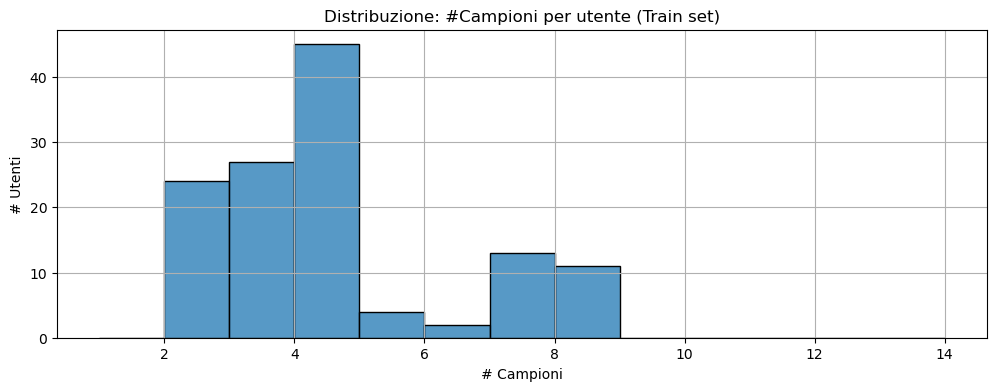

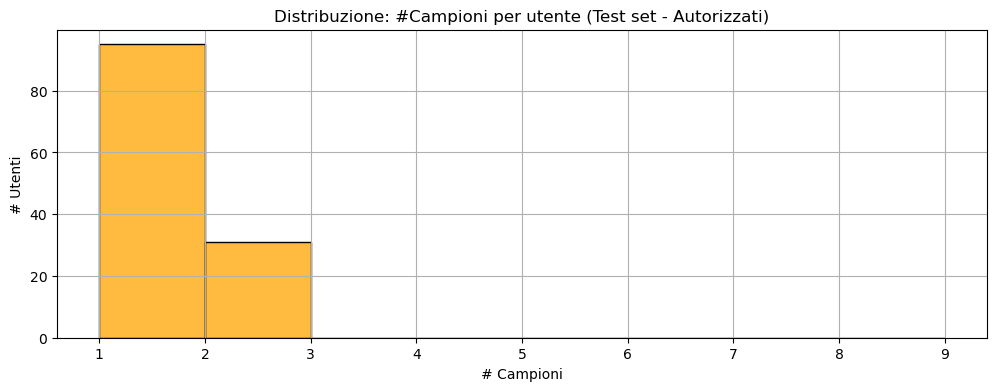

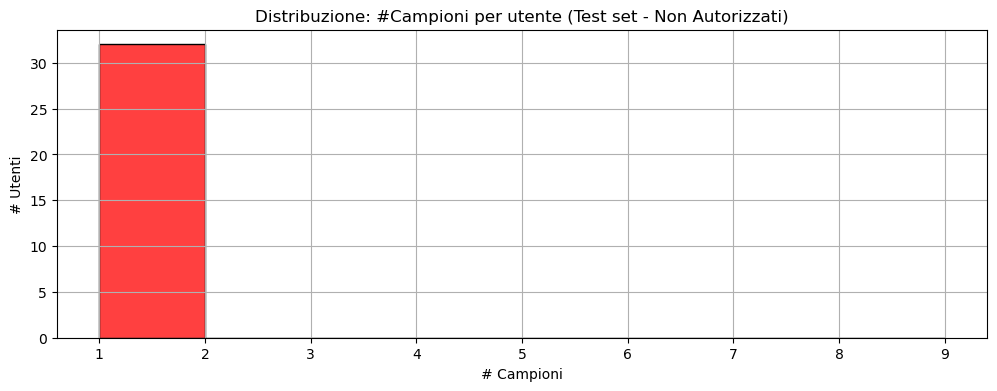

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def get_writer_id(idx):
    return dataset[idx][1]

# Ricostruisci i writer_id
train_writer_ids = [get_writer_id(i) for i in train_indices]
test_writer_ids = [get_writer_id(i) for i in test_indices]

# Separazione test: autorizzati vs non autorizzati
test_auth_ids = [i for i in test_writer_ids if i in authorized_writers]
test_unauth_ids = [i for i in test_writer_ids if i in unauthorized_writers]

# Conta campioni per utente
train_count = Counter(train_writer_ids)
test_auth_count = Counter(test_auth_ids)
test_unauth_count = Counter(test_unauth_ids)

# Statistiche generali
print("🧾 Statistiche principali")
print(f"- Utenti autorizzati: {len(authorized_writers)}")
print(f"  ↳ Campioni totali nel train set: {len(train_indices)}")
print(f"  ↳ Utenti nel train set: {len(train_count)}")
print(f"  ↳ Utenti autorizzati nel test set: {len(test_auth_count)}")

# Nuovi calcoli aggiunti qui
num_test_auth_samples = sum(test_auth_count.values())
mean_test_auth_samples = num_test_auth_samples / len(test_auth_count) if len(test_auth_count) > 0 else 0

print(f"  ↳ Campioni autorizzati nel test set: {num_test_auth_samples}")
print(f"  ↳ Media campioni test per utente autorizzato: {mean_test_auth_samples:.2f}")

print(f"- Utenti non autorizzati totali: {len(unauthorized_writers)}")
print(f"  ↳ Utenti non autorizzati nel test set: {len(test_unauth_count)}")
print(f"  ↳ Campioni non autorizzati nel test set: {sum(test_unauth_count.values())}")

# ————————————————————————————————————————————————————
# 📊 1. Istogramma: campioni per utente (train)
plt.figure(figsize=(12, 4))
sns.histplot(list(train_count.values()), bins=range(1, 15), kde=False)
plt.title("Distribuzione: #Campioni per utente (Train set)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()

# 📊 2. Istogramma: campioni per utente (Test - Autorizzati)
plt.figure(figsize=(12, 4))
sns.histplot(list(test_auth_count.values()), bins=range(1, 10), kde=False, color='orange')
plt.title("Distribuzione: #Campioni per utente (Test set - Autorizzati)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()

# 📊 3. Istogramma: campioni per utente (Test - Non autorizzati)
plt.figure(figsize=(12, 4))
sns.histplot(list(test_unauth_count.values()), bins=range(1, 10), kde=False, color='red')
plt.title("Distribuzione: #Campioni per utente (Test set - Non Autorizzati)")
plt.xlabel("# Campioni")
plt.ylabel("# Utenti")
plt.grid(True)
plt.show()


In [12]:
import torch
import os

split = {
    'train_indices': train_indices,
    'test_indices': test_indices,
    'label_map': label_map
}

os.makedirs('splits', exist_ok=True)
torch.save(split, 'splits/dataset_split.pth')
